In [1]:
'''
This notebook compares the results of three models (time standardization is used for preprocessing across all models):
0) vanilla sequence model trained on (s,a) -> s' examples.
1) bayesian sequence model trained on (s,a) -> s' examples. Liklihood std=0.01
2) bayesian sequence model trained on s0, {a0...aT} -> s' examples. Liklihood std=0.01
'''

"\nThis notebook compares the results of three models (time standardization is used for preprocessing across all models):\n0) vanilla sequence model trained on (s,a) -> s' examples.\n1) bayesian sequence model trained on (s,a) -> s' examples. Liklihood std=0.01\n2) bayesian sequence model trained on s0, {a0...aT} -> s' examples. Liklihood std=0.01\n"

In [2]:
%load_ext autoreload
%autoreload 2

In [71]:
import numpy as np
import os
import torch
import time

import pyro
import pyro.optim as optim
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO

import vanilla_rnn
import bayesian_rnn_experimental
import bayesian_rnn_without_bias
from utils.visualize import *
from utils.tools import *
import wandb

In [4]:
root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = root+"/../datasets/vanilla_rnn"
X_train, A_train, Y_train = np.load(dataset+"/train/states.npy"), np.load(dataset+"/train/actions.npy"), np.load(dataset+"/train/next_states.npy")
X_val, A_val, Y_val = np.load(dataset+"/val/states.npy"), np.load(dataset+"/val/actions.npy"), np.load(dataset+"/val/next_states.npy")
X_test, A_test, Y_test = np.load(dataset+"/test/states.npy"), np.load(dataset+"/test/actions.npy"), np.load(dataset+"/test/next_states.npy")

X_train, Y_train = standardize_across_time(X_train), standardize_across_time(Y_train) 
X_val, Y_val = standardize_across_time(X_val), standardize_across_time(Y_val) 
X_test, Y_test = standardize_across_time(X_test), standardize_across_time(Y_test) 

# X_train, muX, sigmaX = standardize_across_samples(X_train, params=True)
# Y_train, muY, sigmaY = standardize_across_samples(Y_train, params=True) 
# X_val, Y_val = standardize_across_samples(X_val, mu=muX, sigma=sigmaX), standardize_across_samples(Y_val, mu=muY, sigma=sigmaY) 
# X_test, Y_test = standardize_across_samples(X_test,mu=muX, sigma=sigmaX), standardize_across_samples(Y_test, mu=muY, sigma=sigmaY) 

In [5]:
rnn0 = vanilla_rnn.SequenceModel(state_dim=21, action_dim=8, latent_dim=256, num_recurrent_layers=1, device=device).to(device)

In [6]:
rnn0.load_state_dict(torch.load(root+"/../models/best_vanilla_rnn_time_standardization.pth")['model_state_dict'])

<All keys matched successfully>

In [7]:
config = {
    "dataset"           :   dataset,
    "state_size"        :   X_train.shape[-1],
    "action_size"       :   A_train.shape[-1],
    "z_size"            :   32,
    "hidden_state_size" :   256,
    "likelihood_std"    :   0.01,
    "epochs"            :   10000,
    "batch_size"        :   1600,
    "learning_rate"     :   1.0e-3,
    "device"            :   device,
    "preprocessing"     :   "standardization across batch"
}
vrnn1 = bayesian_rnn_experimental.BayesianSequenceModel(state_size=config["state_size"], 
                             action_size=config["action_size"], 
                             z_size=config["z_size"], 
                             hidden_state_size=config["hidden_state_size"], 
                             likelihood_std=config["likelihood_std"],
                             device=device,
                             path=root+"/wandb/run-20200416_215750-326kb0l8/honshu_likelihood_std=0.01+time_standardization+(s,a)->s'_bayesian_rnn_time_standardization_model.pth").to(device)
vrnn1.load_checkpoint()

In [8]:
config = {
    "dataset"           :   dataset,
    "state_size"        :   X_train.shape[-1],
    "action_size"       :   A_train.shape[-1],
    "z_size"            :   128,
    "hidden_state_size" :   512,
    "likelihood_std"    :   0.01,
    "epochs"            :   50,
    "batch_size"        :   1600,
    "learning_rate"     :   1.0e-3,
    "device"            :   device,
    "preprocessing"     :   "standardization across batch"
}
vrnn2 = bayesian_rnn_without_bias.BayesianSequenceModel(state_size=config["state_size"], 
                             action_size=config["action_size"], 
                             z_size=config["z_size"], 
                             hidden_state_size=config["hidden_state_size"], 
                             likelihood_std=config["likelihood_std"],
                             device=device,
                             path=root+"/wandb/run-20200415_233445-3sisbivl/tesla_likelihood_std=0.01+time_standardization_bayesian_rnn_model_without_bias.pth").to(device)
vrnn2.load_checkpoint()

In [9]:
X_train=torch.from_numpy(X_train[:]).to(device)
A_train=torch.from_numpy(A_train[:]).to(device)
Y_train=torch.from_numpy(Y_train[:]).to(device)

X_val=torch.from_numpy(X_val[:]).to(device)
A_val=torch.from_numpy(A_val[:]).to(device)
Y_val=torch.from_numpy(Y_val[:]).to(device)

X_test=torch.from_numpy(X_test[:]).to(device)
A_test=torch.from_numpy(A_test[:]).to(device)
Y_test=torch.from_numpy(Y_test[:]).to(device)

In [10]:
# PREDICTION WITHOUT UNCERTAINTY ESTIMATES

In [174]:
n = 0
t=100
Y_hat0 = rnn0.foresee(x=X_train[n:n+1].data.cpu().numpy(), a=A_train[n:n+1].data.cpu().numpy(), lookahead=t)
Y_hat1, O1 = vrnn1.predict(X=X_train[n:n+1, :, :], A=A_train[n:n+1, :, :], Y=Y_train[n:n+1, :, :], lookahead=t)
Y_hat2, O2 = vrnn2.predict(x=X_train[n:n+1, 0:1, :], A=A_train[n:n+1, :, :], Y=Y_train[n:n+1, :, :])

In [12]:
n = 50
t=1
Y_hat0 = rnn0.foresee(x=X_val[n:n+1].data.cpu().numpy(), a=A_val[n:n+1].data.cpu().numpy(), lookahead=t)
Y_hat1, O1 = vrnn1.predict(X=X_val[n:n+1, :, :], A=A_val[n:n+1, :, :], Y=Y_val[n:n+1, :, :], lookahead=t)
Y_hat2, O2 = vrnn2.predict(x=X_val[n:n+1, 0:1, :], A=A_val[n:n+1, :, :], Y=Y_val[n:n+1, :, :])

In [175]:
n = 5
t=100
Y_hat0 = rnn0.foresee(x=X_test[n:n+1].data.cpu().numpy(), a=A_test[n:n+1].data.cpu().numpy(), lookahead=t)
Y_hat1, O1 = vrnn1.predict(X=X_test[n:n+1, :, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :], lookahead=t)
Y_hat2, O2 = vrnn2.predict(x=X_test[n:n+1, 0:1, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :])

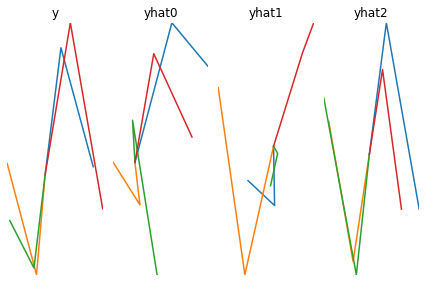

<Figure size 432x288 with 0 Axes>

In [14]:
compare_multimodel_states(Y=Y_test[n].data.cpu().numpy(), Y_hats=(Y_hat0[0], Y_hat1[0], Y_hat2[0]))            # animation of joints

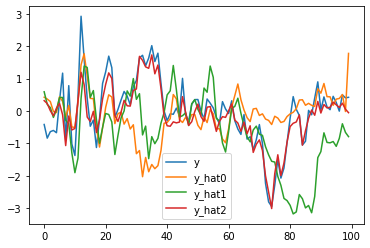

In [160]:
# VELOCITIES
plot_multimodel_velocity_curve(true=Y_test[n, :, 0].data.cpu().numpy(), pred=(Y_hat0[0, :, 0], Y_hat1[0, :, 0], Y_hat2[0, :, 0])) # x-velocity

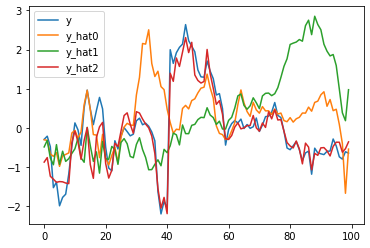

In [161]:
plot_multimodel_velocity_curve(true=Y_test[n, :, 1].data.cpu().numpy(), pred=(Y_hat0[0, :, 1], Y_hat1[0, :, 1], Y_hat2[0, :, 1])) # y-velocity

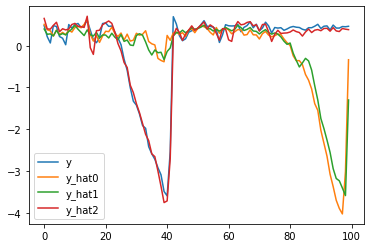

In [162]:
plot_multimodel_velocity_curve(true=Y_test[n, :, 2].data.cpu().numpy(), pred=(Y_hat0[0, :, 2], Y_hat1[0, :, 2], Y_hat2[0, :, 2])) # z-velocity

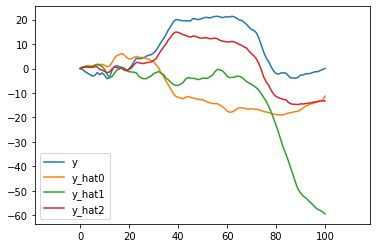

In [163]:
# POSITIONS
plot_multimodel_position_curve(true=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0[0, :, 0]), compute_position_from_velocity(Y_hat1[0, :, 0]), compute_position_from_velocity(Y_hat2[0, :, 0])), axis='equal') # x-position

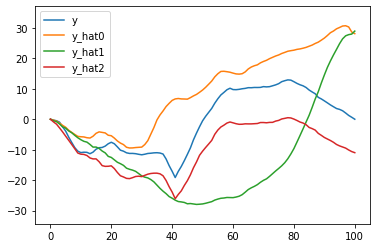

In [164]:
plot_multimodel_position_curve(true=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0[0, :, 1]), compute_position_from_velocity(Y_hat1[0, :, 1]), compute_position_from_velocity(Y_hat2[0, :, 1])), axis='equal') # y-position

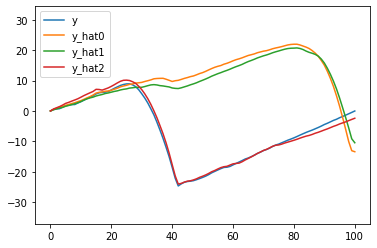

In [165]:
plot_multimodel_position_curve(true=compute_position_from_velocity(Y_test[n, :, 2].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0[0, :, 2]), compute_position_from_velocity(Y_hat1[0, :, 2]), compute_position_from_velocity(Y_hat2[0, :, 2])), axis='equal') # z-position

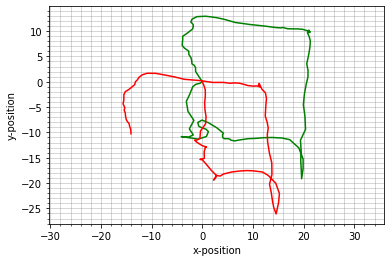

In [176]:
plot_2D_position_curve(trueX=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), trueY=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), predX=compute_position_from_velocity(Y_hat2[0, :, 0]), predY=compute_position_from_velocity(Y_hat2[0, :, 1]), axis='equal')

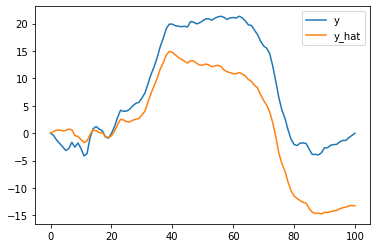

In [167]:
plot_position_curve(true=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2[0, :, 0])) # x-position

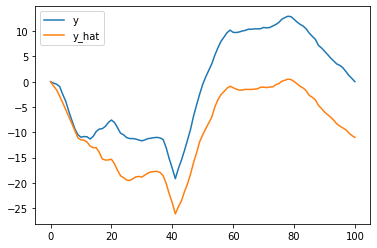

In [168]:
plot_position_curve(true=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2[0, :, 1])) # y-position

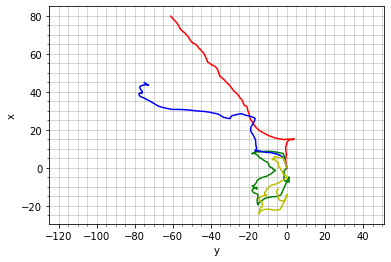

In [139]:
plot_multimodel_2D_position_curve(trueX=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), trueY=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), predX=(compute_position_from_velocity(Y_hat0[0, :, 0]), compute_position_from_velocity(Y_hat1[0, :, 0]), compute_position_from_velocity(Y_hat2[0, :, 0])), predY=(compute_position_from_velocity(Y_hat0[0, :, 1]), compute_position_from_velocity(Y_hat1[0, :, 1]), compute_position_from_velocity(Y_hat2[0, :, 1])), axis='equal') # xy-position

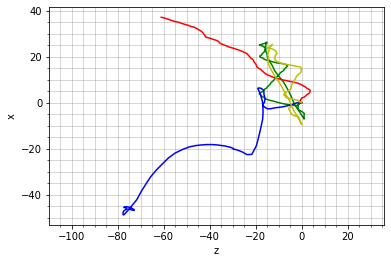

In [140]:
plot_multimodel_2D_position_curve(trueX=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), trueY=compute_position_from_velocity(Y_test[n, :, 2].data.cpu().numpy()), predX=(compute_position_from_velocity(Y_hat0[0, :, 0]), compute_position_from_velocity(Y_hat1[0, :, 0]), compute_position_from_velocity(Y_hat2[0, :, 0])), predY=(compute_position_from_velocity(Y_hat0[0, :, 2]), compute_position_from_velocity(Y_hat1[0, :, 2]), compute_position_from_velocity(Y_hat2[0, :, 2])), xlabel='x', ylabel='z', axis='equal') # xz-position

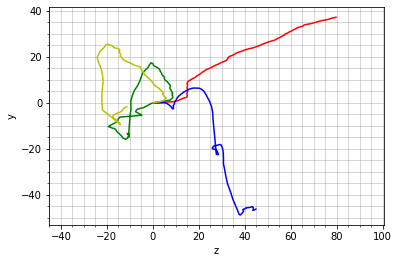

In [141]:
plot_multimodel_2D_position_curve(trueX=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), trueY=compute_position_from_velocity(Y_train[n, :, 2].data.cpu().numpy()), predX=(compute_position_from_velocity(Y_hat0[0, :, 1]), compute_position_from_velocity(Y_hat1[0, :, 1]), compute_position_from_velocity(Y_hat2[0, :, 1])), predY=(compute_position_from_velocity(Y_hat0[0, :, 2]), compute_position_from_velocity(Y_hat1[0, :, 2]), compute_position_from_velocity(Y_hat2[0, :, 2])), xlabel='y', ylabel='z', axis='equal') # yz-position

In [24]:
# PREDICTION WITH UNCERTAINTY ESTIMATES

In [25]:
n = 0
t=100
samples=100
Y_hat0 = rnn0.foresee(x=X_test[n:n+1].data.cpu().numpy(), a=A_test[n:n+1].data.cpu().numpy(), lookahead=t)
Y_hat0_mean, Y_hat0_lower, Y_hat0_upper = Y_hat0, Y_hat0, Y_hat0
Y_hat1_mean, Y_hat1_std, Y_hat1_lower, Y_hat1_upper = vrnn1.predict_with_uncertainty(X=X_test[n:n+1, :, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :], lookahead=t, samples=samples)
Y_hat2_mean, Y_hat2_std, Y_hat2_lower, Y_hat2_upper = vrnn2.predict_with_uncertainty(x=X_test[n:n+1, 0:1, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :], samples=samples)

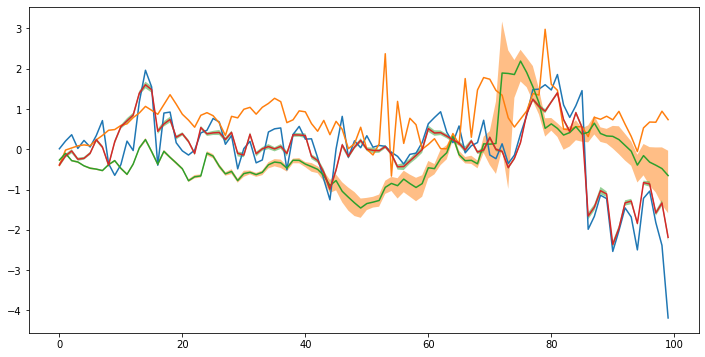

In [26]:
# VELOCITIES
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, 0].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 0], Y_hat1_mean[0, :, 0], Y_hat2_mean[0, :, 0]), error1=(Y_hat0_lower[0, :, 0], Y_hat1_lower[0, :, 0], Y_hat2_lower[0, :, 0]), error2=(Y_hat0_upper[0, :, 0], Y_hat1_upper[0, :, 0], Y_hat2_upper[0, :, 0]), axis=None) # x-velocity

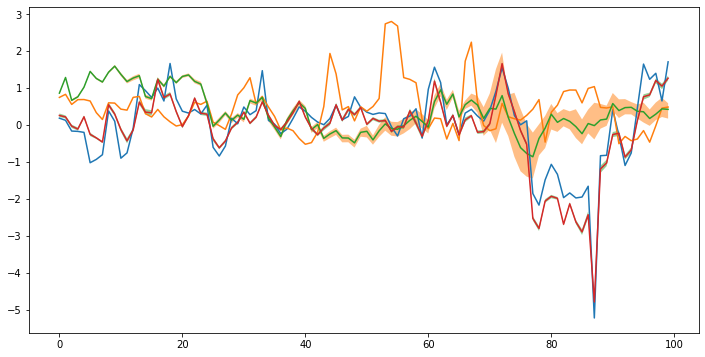

In [27]:
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, 1].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 1], Y_hat1_mean[0, :, 1], Y_hat2_mean[0, :, 1]), error1=(Y_hat0_lower[0, :, 1], Y_hat1_lower[0, :, 1], Y_hat2_lower[0, :, 1]), error2=(Y_hat0_upper[0, :, 1], Y_hat1_upper[0, :, 1], Y_hat2_upper[0, :, 1]), axis=None) # y-velocity

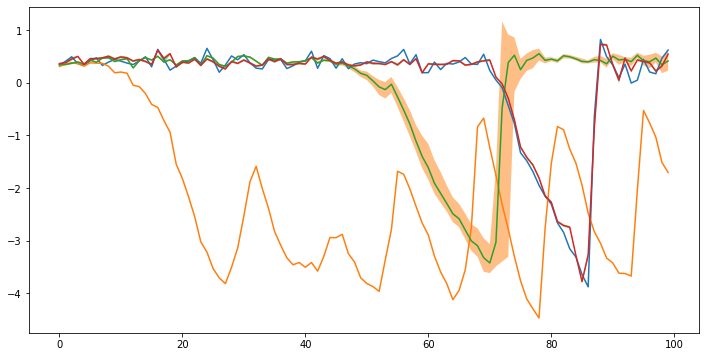

In [28]:
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, 2].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 2], Y_hat1_mean[0, :, 2], Y_hat2_mean[0, :, 2]), error1=(Y_hat0_lower[0, :, 2], Y_hat1_lower[0, :, 2], Y_hat2_lower[0, :, 2]), error2=(Y_hat0_upper[0, :, 2], Y_hat1_upper[0, :, 2], Y_hat2_upper[0, :, 2]), axis=None) # z-velocity

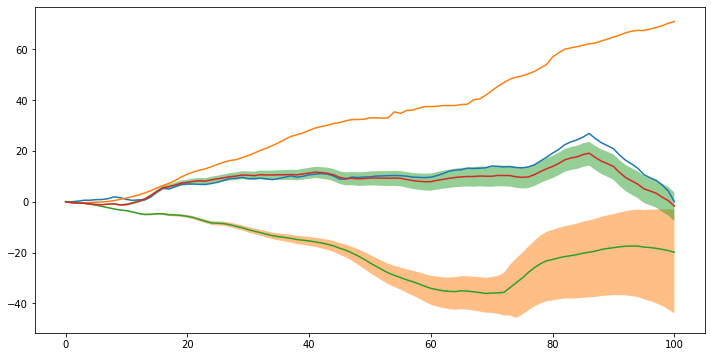

In [29]:
# POSITIONS
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 0]), compute_position_from_velocity(Y_hat1_mean[0, :, 0]), compute_position_from_velocity(Y_hat2_mean[0, :, 0])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 0]), compute_position_from_velocity(Y_hat1_lower[0, :, 0]), compute_position_from_velocity(Y_hat2_lower[0, :, 0])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 0]), compute_position_from_velocity(Y_hat1_upper[0, :, 0]), compute_position_from_velocity(Y_hat2_upper[0, :, 0])), axis=None) # x-position

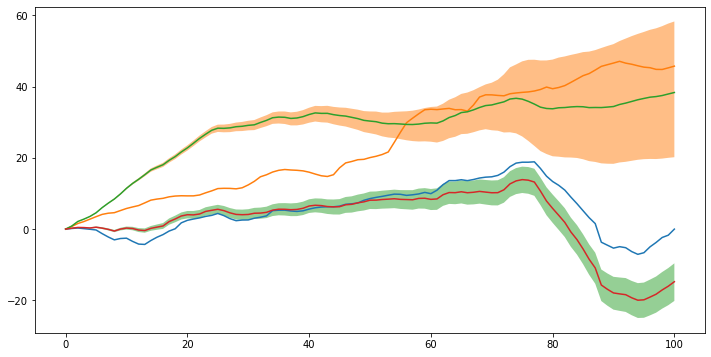

In [30]:
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 1]), compute_position_from_velocity(Y_hat1_mean[0, :, 1]), compute_position_from_velocity(Y_hat2_mean[0, :, 1])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 1]), compute_position_from_velocity(Y_hat1_lower[0, :, 1]), compute_position_from_velocity(Y_hat2_lower[0, :, 1])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 1]), compute_position_from_velocity(Y_hat1_upper[0, :, 1]), compute_position_from_velocity(Y_hat2_upper[0, :, 1])), axis=None) # y-position

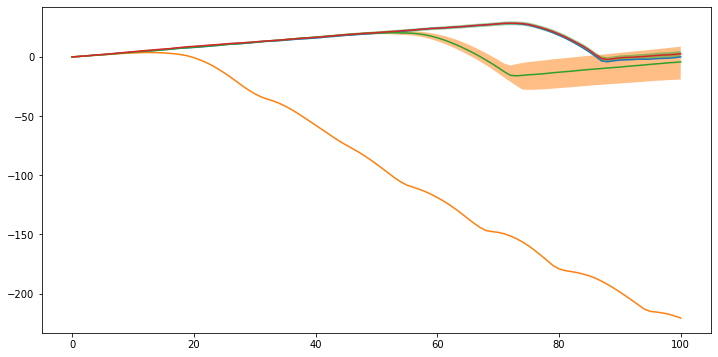

In [31]:
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 2].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 2]), compute_position_from_velocity(Y_hat1_mean[0, :, 2]), compute_position_from_velocity(Y_hat2_mean[0, :, 2])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 2]), compute_position_from_velocity(Y_hat1_lower[0, :, 2]), compute_position_from_velocity(Y_hat2_lower[0, :, 2])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 2]), compute_position_from_velocity(Y_hat1_upper[0, :, 2]), compute_position_from_velocity(Y_hat2_upper[0, :, 2])), axis=None) # z-position

In [32]:
# PREDICTION ON LONG-HORIZON (T=1000)
X_long, A_long, Y_long = np.load(dataset+"/../long_sequence/states.npy"), np.load(dataset+"/../long_sequence/actions.npy"), np.load(dataset+"/../long_sequence/next_states.npy")
X_long, Y_long = standardize_across_time(X_long), standardize_across_time(Y_long) 

In [33]:
X_long=torch.from_numpy(X_long[:]).to(device)
A_long=torch.from_numpy(A_long[:]).to(device)
Y_long=torch.from_numpy(Y_long[:]).to(device)

In [73]:
n = 0
t=100
samples=100
Y_hat0 = rnn0.foresee(x=X_long[n:n+1].data.cpu().numpy(), a=A_long[n:n+1].data.cpu().numpy(), lookahead=t)
Y_hat0_mean, Y_hat0_lower, Y_hat0_upper = Y_hat0, Y_hat0, Y_hat0
Y_hat1_mean, Y_hat1_std, Y_hat1_lower, Y_hat1_upper = vrnn1.predict_with_uncertainty(X=X_long[n:n+1, :, :], A=A_long[n:n+1, :, :], Y=Y_long[n:n+1, :, :], lookahead=t, samples=samples)
Y_hat2_mean, Y_hat2_std, Y_hat2_lower, Y_hat2_upper = vrnn2.predict_with_uncertainty(x=X_long[n:n+1, 0:1, :], A=A_long[n:n+1, :, :], Y=Y_long[n:n+1, :, :], samples=samples)

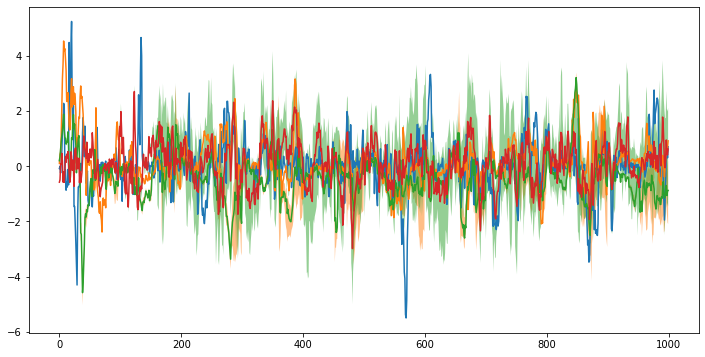

In [74]:
# VELOCITIES
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_long[n, :, 0].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 0], Y_hat1_mean[0, :, 0], Y_hat2_mean[0, :, 0]), error1=(Y_hat0_lower[0, :, 0], Y_hat1_lower[0, :, 0], Y_hat2_lower[0, :, 0]), error2=(Y_hat0_upper[0, :, 0], Y_hat1_upper[0, :, 0], Y_hat2_upper[0, :, 0]), axis=None) # x-velocity

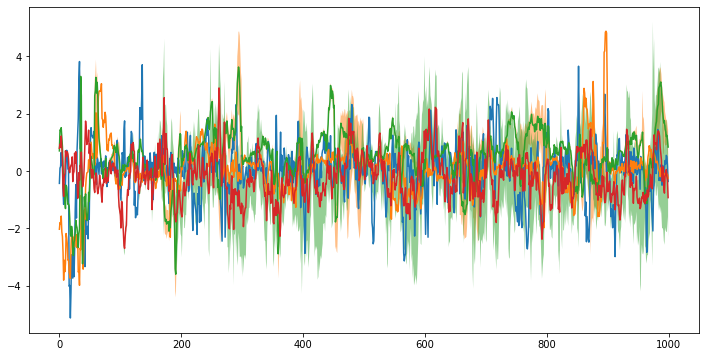

In [75]:
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_long[n, :, 1].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 1], Y_hat1_mean[0, :, 1], Y_hat2_mean[0, :, 1]), error1=(Y_hat0_lower[0, :, 1], Y_hat1_lower[0, :, 1], Y_hat2_lower[0, :, 1]), error2=(Y_hat0_upper[0, :, 1], Y_hat1_upper[0, :, 1], Y_hat2_upper[0, :, 1]), axis=None) # y-velocity

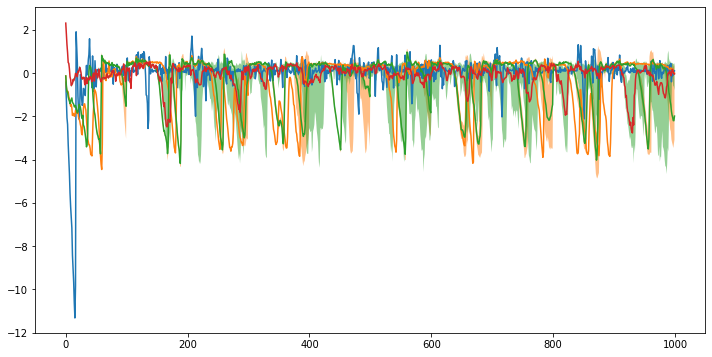

In [76]:
plot_multimodel_velocity_curve_with_uncertainty_shaded(true=Y_long[n, :, 2].data.cpu().numpy(), pred=(Y_hat0_mean[0, :, 2], Y_hat1_mean[0, :, 2], Y_hat2_mean[0, :, 2]), error1=(Y_hat0_lower[0, :, 2], Y_hat1_lower[0, :, 2], Y_hat2_lower[0, :, 2]), error2=(Y_hat0_upper[0, :, 2], Y_hat1_upper[0, :, 2], Y_hat2_upper[0, :, 2]), axis=None) # z-velocity

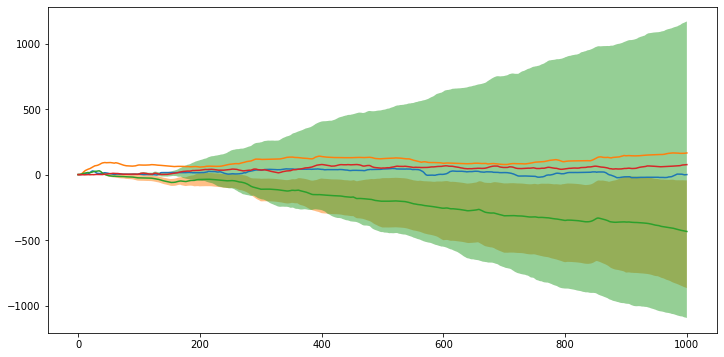

In [77]:
# POSITIONS
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_long[n, :, 0].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 0]), compute_position_from_velocity(Y_hat1_mean[0, :, 0]), compute_position_from_velocity(Y_hat2_mean[0, :, 0])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 0]), compute_position_from_velocity(Y_hat1_lower[0, :, 0]), compute_position_from_velocity(Y_hat2_lower[0, :, 0])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 0]), compute_position_from_velocity(Y_hat1_upper[0, :, 0]), compute_position_from_velocity(Y_hat2_upper[0, :, 0])), axis=None) # x-position

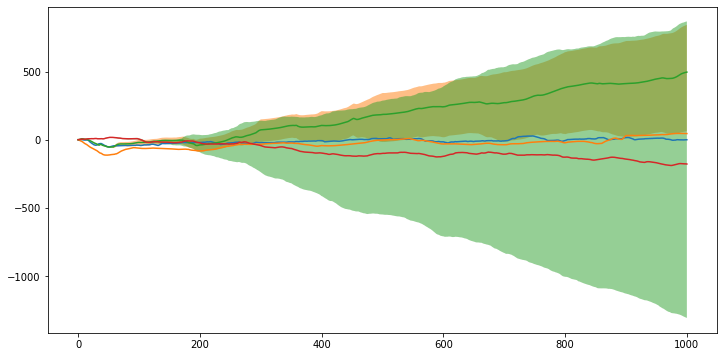

In [78]:
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_long[n, :, 1].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 1]), compute_position_from_velocity(Y_hat1_mean[0, :, 1]), compute_position_from_velocity(Y_hat2_mean[0, :, 1])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 1]), compute_position_from_velocity(Y_hat1_lower[0, :, 1]), compute_position_from_velocity(Y_hat2_lower[0, :, 1])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 1]), compute_position_from_velocity(Y_hat1_upper[0, :, 1]), compute_position_from_velocity(Y_hat2_upper[0, :, 1])), axis=None) # y-position

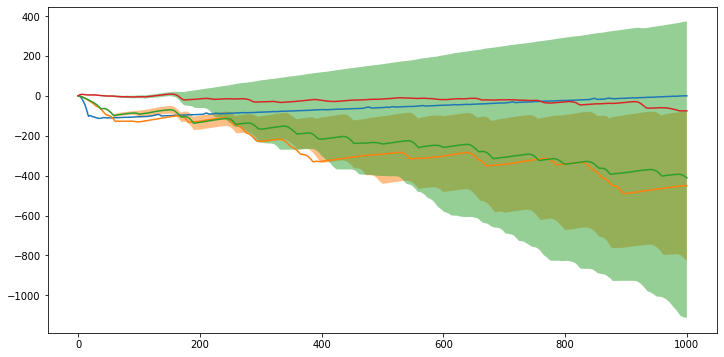

In [79]:
plot_multimodel_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_long[n, :, 2].data.cpu().numpy()), pred=(compute_position_from_velocity(Y_hat0_mean[0, :, 2]), compute_position_from_velocity(Y_hat1_mean[0, :, 2]), compute_position_from_velocity(Y_hat2_mean[0, :, 2])), error1=(compute_position_from_velocity(Y_hat0_lower[0, :, 2]), compute_position_from_velocity(Y_hat1_lower[0, :, 2]), compute_position_from_velocity(Y_hat2_lower[0, :, 2])), error2=(compute_position_from_velocity(Y_hat0_upper[0, :, 2]), compute_position_from_velocity(Y_hat1_upper[0, :, 2]), compute_position_from_velocity(Y_hat2_upper[0, :, 2])), axis=None) # z-position

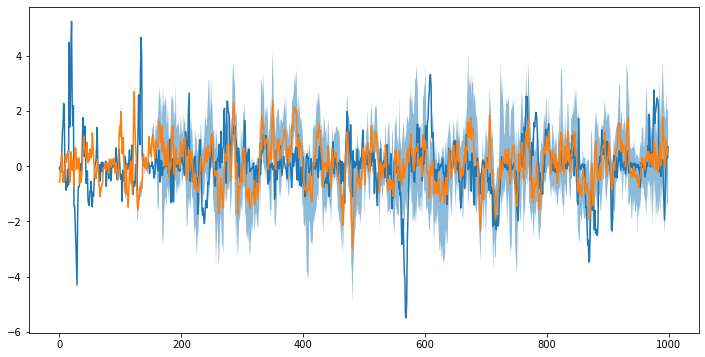

In [80]:
i = 0
plot_velocity_curve_with_uncertainty_shaded(true=Y_long[n, :, i].data.cpu().numpy(), pred=Y_hat2_mean[0, :, i], error1=Y_hat2_lower[0, :, i], error2=Y_hat2_upper[0, :, i], axis=None) # x-velocity

In [81]:
plot_curve_plotly(true=Y_long[n, :, 0].data.cpu().numpy(), pred=Y_hat2_mean[0, :, 0])

In [82]:
plot_curve_plotly(true=Y_long[n, :, 1].data.cpu().numpy(), pred=Y_hat2_mean[0, :, 1])

In [83]:
plot_curve_plotly(true=Y_long[n, :, 2].data.cpu().numpy(), pred=Y_hat2_mean[0, :, 2])

In [104]:
plot_curve_plotly(true=compute_position_from_velocity(Y_long[n, :, 0].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2_mean[0, :, 0]))

In [95]:
plot_curve_plotly(true=compute_position_from_velocity(Y_long[n, :, 1].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2_mean[0, :, 1]))

In [99]:
plot_curve_plotly(true=compute_position_from_velocity(Y_long[n, :, 2].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2_mean[0, :, 2]))

In [87]:
plot_curve_with_uncertainty_shaded_plotly(true=compute_position_from_velocity(Y_long[n, :, 0].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2_mean[0, :, 0]), error1=compute_position_from_velocity(Y_hat2_lower[0, :, 0]), error2=compute_position_from_velocity(Y_hat2_upper[0, :, 0])) # x-position

In [88]:
plot_curve_with_uncertainty_shaded_plotly(true=compute_position_from_velocity(Y_long[n, :, 1].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat2_mean[0, :, 1]), error1=compute_position_from_velocity(Y_hat2_lower[0, :, 1]), error2=compute_position_from_velocity(Y_hat2_upper[0, :, 1])) # x-position

In [89]:
plot_xy_curve_with_uncertainty_shaded_plotly(true=(compute_position_from_velocity(Y_long[n, :, 0].data.cpu().numpy()), compute_position_from_velocity(Y_long[n, :, 1].data.cpu().numpy())), pred=(compute_position_from_velocity(Y_hat2_mean[0, :, 0]), compute_position_from_velocity(Y_hat2_mean[0, :, 1])), error1=(compute_position_from_velocity(Y_hat2_lower[0, :, 0]), compute_position_from_velocity(Y_hat2_lower[0, :, 1])), error2=(compute_position_from_velocity(Y_hat2_upper[0, :, 0]), compute_position_from_velocity(Y_hat2_upper[0, :, 1]))) # x-position